# Divide ocean region into unstructured patches

In [46]:
import os
from glob import glob
import random
import gsw

import numpy as np
import xarray as xr
import pop_tools

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib import gridspec

import cmocean
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull, Delaunay

import math
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

## Get the grid ready: identify coastline and EEZ

Identify coastline in grid

In [47]:
def add_coast_mask(grid):
    
    '''Add coastline mask to POP grid
    
    Find coastline coordinates in POP grid: look for sharp gradient of KMT, first make 0 KMT to be 0.0001
    
    Key: calculate gradients between lon = 319 and nlon = 0 
    '''
    
    ocean_mask = (grid.KMT > 0).values

    # Replace zeros with 1e-4 using np.where()
    kmt = grid.KMT.values
    kmt_ = np.where(kmt == 0, 1e5, kmt)

    # Calculate the gradients in both dimensions
    gradient_x, gradient_y = np.gradient(kmt_)

    # Compute the magnitude of the gradients
    gradient_magnitude = np.sqrt(gradient_x ** 2 + gradient_y ** 2)

    # for nlon = 319, and nlon = 0, at the edge of POP grid
    grad_x, grad_y = np.gradient(kmt_[:, [0, 319]])
    gradient_edge = np.sqrt(grad_x ** 2 + grad_y ** 2)

    # Find the indices where the gradient magnitude exceeds the threshold
    coast_indices = np.where(gradient_magnitude > 40000)
    coast_indices_edge = np.where(gradient_edge > 40000)

    # conbime the 2 arrays
    coast_indices_edge_nlon = coast_indices_edge[1]
    coast_indices_edge_nlon[np.where(coast_indices_edge_nlon == 1)] = 319  # the 2nd column is 319
    whole_nlat = np.concatenate((coast_indices[0], coast_indices_edge[0]))
    whole_nlon = np.concatenate((coast_indices[1], coast_indices_edge_nlon))
    coast_indices = (whole_nlat, whole_nlon)

    # coastline mask in POP grid
    coast_mask = np.zeros(kmt.shape)
    for i in range(coast_indices[0].shape[0]):
        j = coast_indices[0][i] # nlat
        k = coast_indices[1][i] # nlon

        coast_mask[j,k] = 1

    coast_mask = coast_mask*ocean_mask
    grid['coast_mask'] = xr.DataArray(data=coast_mask, dims=['nlat', 'nlon'])
    
    return grid, coast_indices

Get POP grid, and add coastline mask

In [48]:
grid_name = 'POP_gx1v7'
grid = pop_tools.get_grid(grid_name)
grid, coast_indices = add_coast_mask(grid) # identify coastline indices in POP grid and add them to 

In [49]:
tlong = grid.TLONG.values
tlat = grid.TLAT.values

ocean_mask = (grid.KMT > 0).values # ocean mask as a numpy array
coastal_mask = grid['coast_mask'].astype(np.int32)  # coastline mask, this is in the ocean, not on land

Idensity EEZ, 370km from the coastline

In [50]:
def find_points_within_square(i, j, grid_shape, tol=2):
    
    '''To find all the points' indices that are within a square of length 4, 
    centered at a given point index (i, j) in a 2D grid,
    Search more points along y, to account for the unevenly spaced y'''
    
    m, n = grid_shape
    # index of close points
    ind_x = []
    ind_y = []
    
    for x in range(max(0, i - tol*2), min(i + tol*2 + 1, m)):
        for y in range(max(0, j - tol), min(j + tol + 1, n)):
            #indices.append((x, y))
            ind_x.append(x)
            ind_y.append(y)
    
    return ind_x, ind_y

In [51]:
%%time
threshold_distance = 370  # in kilometers

# Create empty arrays for distances and region mask
region_mask_eez = np.zeros_like(coastal_mask)
region_mask_pools = np.zeros_like(coastal_mask)

# loop each coastline grid index, and find points in the ocean that are close to it
for i in range(coast_indices[0].shape[0]):
    coast_nlat =  coast_indices[0][i]
    coast_nlon =  coast_indices[1][i]
    
    #  1 coastal point coords
    point = [tlong[coast_nlat, coast_nlon], tlat[coast_nlat, coast_nlon]]

    # indices of the close points
    close_points_x, close_points_y = find_points_within_square(coast_nlat, coast_nlon, grid.TLONG.shape, 5)
    region_mask_pools[close_points_x, close_points_y] = 1 # the pools to select from
    
    # coordinates of the close points to be searched based on the distance
    tlong_close = tlong[close_points_x, close_points_y]
    tlat_close = tlat[close_points_x, close_points_y]
    
    # loop each caostal point, with a limited search domain, find EEZ
    for j in range(len(close_points_x)):
        if ocean_mask[close_points_x[j], close_points_y[j]]: # in the ocean
            if gsw.distance([tlong_close[j], point[0]],  [tlat_close[j], point[1]]) <= threshold_distance*1000: # within distance threshold
                region_mask_eez[close_points_x[j], close_points_y[j]] = 1

CPU times: user 1min 2s, sys: 3.87 ms, total: 1min 2s
Wall time: 1min 11s


You can also save the EEZ mask for future

In [52]:
grid['eez_mask'] = xr.DataArray(data=region_mask_eez, dims=['nlat', 'nlon'])
#grid.to_netcdf('./pop_grid_eez.nc', mode='w')

Selected EEZ grid points

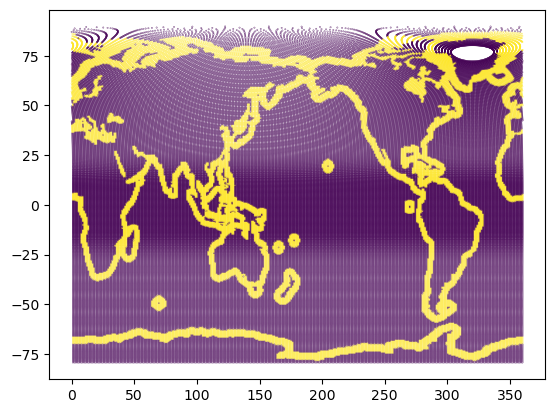

In [53]:
plt.scatter(tlong, tlat, c=region_mask_eez, s=0.05)

# Unstructured mesh: unsupervised learning
* Use Kmeans to cluster the points, using longitude and latitude
* Trick: run get_polygons with num_polygons=101 first, and run the plot_polygons with remove=[], then chose the ones you want to remove, run plot_polygons again. You will have 100 at the end.

Functions needed

In [54]:
def convert_longitudes(longitudes):
    '''Convert longitudes from (0,360) to (-180,180)'''
    
    converted_longitudes = np.where(longitudes > 180, longitudes - 360, longitudes)
    
    return converted_longitudes

def get_coords(mask_atlantic, convert_lon=True):
    '''Given an ocean mask, return the selected lon(-180,180) and lat
    convert_lon: to make longitude continuous, like Atlantic, but not Pacific
    '''
    
    # Find the indices of the atlantic ocean in the mask, extract lon, lat
    atlantic_indices = np.where(mask_atlantic == 1)

    # we need to conver longitude from a range of 0 - 360, to a range of -180 to 180. You can put it back after find all pacthes
    tlong_atlantic = tlong[atlantic_indices] 
    tlat_atlantic = tlat[atlantic_indices]
    if convert_lon == True:
        tlong_atlantic = convert_longitudes(tlong_atlantic)
    
    return tlong_atlantic, tlat_atlantic

def get_polygons(mask_atlantic, num_polygons, convert_lon=True, save_ind=False):
    
    '''Given ocean mask, and the number of clusters
    return Kmeans polygon_vertices, cluster_labels, cluster_centers
    convert_lon: to make longitude continuous, like Atlantic, but not Pacific'''
    
    #the selected lon and lat
    tlong_atlantic, tlat_atlantic = get_coords(mask_atlantic, convert_lon)

    np.random.seed(0)

    # construct data points
    data_points = np.vstack((tlong_atlantic, tlat_atlantic)).T # shape of (13563, 2)

    # Apply K-means clustering, run 30 times to get the best centroid
    kmeans = KMeans(n_clusters=num_polygons, n_init=30)
    kmeans.fit(data_points)
    cluster_labels = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_

    # Initialize empty lists to store triangle vertices
    polygon_vertices = [[] for _ in range(num_polygons)]
    polygon_ind_inAtlanticPOP = [[] for _ in range(num_polygons)] # store the index in Atlantic POP grid

    # Post-processing to form polygons
    for i, label in enumerate(cluster_labels):
        polygon_vertices[label].append(data_points[i])
        polygon_ind_inAtlanticPOP[label].append(i)

    polygon_vertices = np.array(polygon_vertices)  # all clusters' coordinates
    
    if save_ind:
        return polygon_vertices, polygon_ind_inAtlanticPOP, cluster_centers
    else:
        return polygon_vertices, cluster_centers


def plot_polygons(polygon_vertices, cluster_centers, lon_extend, lat_extend, remove=[], region='Atlantic', center_lon=0, save=False):    
        
    '''PLot polygons, given:
    polygon_vertices, cluster_centers: polygon coordinates, centers, 
    lon_extend, lat_extend: lon lat extends for plot
    remove: indices in the polygon to remove. You will run with [] to see which ones you want to remove, and run again with, such as [45,46] 
    center_lon=0 for Atlantic, and 180 for Pacific
    '''
    
    # remove some polygons 
    remove = [num - 1 for num in remove] # index in the plot is from 1
    polygon_vertices = np.delete(polygon_vertices, remove)
    cluster_centers = np.delete(cluster_centers, remove, axis=0) # remove rows

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=center_lon))
    ax.set_extent([*lon_extend, *lat_extend], crs=ccrs.PlateCarree())
    
    # a list of colors
    colors = list(mcolors.TABLEAU_COLORS.values())
    ind_color = np.arange(len(colors)) # 0- 9

    # loop each cluster
    for i in range(len(polygon_vertices)):
        vertices = np.array(polygon_vertices[i])
        if len(vertices) >= 3:
            hull = ConvexHull(vertices) # get the indices of the periphery of a patch, for plotting purpose
            polygon = list(vertices[i] for i in hull.vertices.tolist() )
            polygon = np.array(polygon)

            ax.plot(np.append(polygon[:,0], polygon[0,0]), np.append(polygon[:,1], polygon[0,1]), 'k-', linewidth=0.5, transform=ccrs.PlateCarree())
            #ax.fill(polygon[:, 0], polygon[:, 1], alpha=0.2, transform=ccrs.PlateCarree())

            ax.text(cluster_centers[i, 0]-1.8, cluster_centers[i, 1],str(i+1), fontsize=10, color='k', transform=ccrs.PlateCarree())
            ax.scatter(vertices[:, 0], vertices[:, 1], c=colors[random.choice(ind_color)], s=1, alpha=0.7, transform=ccrs.PlateCarree())

    ax.stock_img()
    ax.set_xticks(np.arange(lon_extend[0]+10, lon_extend[1], 20), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_extend[0]+10, lat_extend[1], 10), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=False)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)  

    ax.set_title(f'{region}, n={len(polygon_vertices)}')
    
    if save==True:
        plt.savefig(f'./figures/{region}_{len(polygon_vertices)}polygons.png', dpi=300, bbox_inches='tight')

def get_polygon_mask(tlong, mask_atlantic, polygon_ind_inAtlanticPOP):
    '''Return a mask for the polygon, given its vertexes
    tlong : POP grid
    '''
    
    # Find the indices of the atlantic ocean in the mask, extract lon, lat
    atlantic_indices = np.where(mask_atlantic == 1)
    
    a,b = tlong.shape
    n = len(polygon_ind_inAtlanticPOP) # number of patches
    
    # polygon mask
    polygon_mask = np.zeros((n,a,b))

    for i in range(n):  
        
        # indices of the polygon points in the Atlantic subset
        polygon_ind_inAtlanticPOP_54 = polygon_ind_inAtlanticPOP[i]

        # indices of selected polygon points in the original POP grid
        polygon_nlat = atlantic_indices[0][polygon_ind_inAtlanticPOP_54]
        polygon_nlon = atlantic_indices[1][polygon_ind_inAtlanticPOP_54]
        

        #  assign 1s
        for j in range(polygon_nlat.shape[0]):  # for each point in a polygon
            polygon_mask[i, polygon_nlat[j], polygon_nlon[j]] = 1

        if np.count_nonzero(polygon_mask[i]) != len(polygon_ind_inAtlanticPOP_54): # make sure the number of 1s in the mask == the number of vertexes in a patch
            print(f'Polygon {i} has different amount of 1s from the number of vertexes in the patch!')
    return polygon_mask

# Generate patches in Atlantic EEZ

In [67]:
mask3d = pop_tools.region_mask_3d(grid_name, mask_name='default')
mask_atlantic =  mask3d.sel(region='Pacific Ocean') 
tlong_atlantic, tlat_atlantic = get_coords(mask_atlantic*region_mask_eez, convert_lon=True)


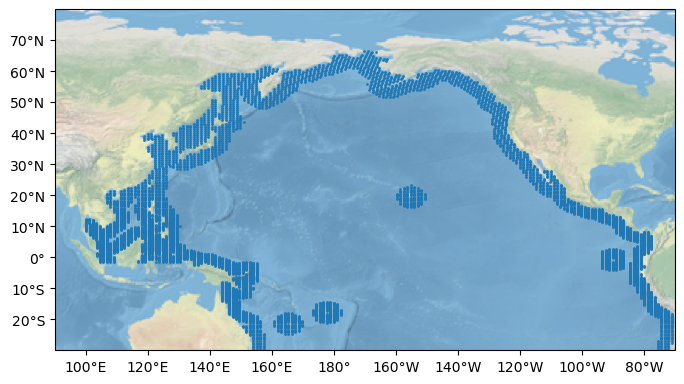

In [68]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax.set_extent([90, 290, -30, 80], crs=ccrs.PlateCarree())

ax.scatter(tlong_atlantic, tlat_atlantic, s=1, alpha=1, transform=ccrs.PlateCarree())

ax.set_xticks(np.arange(100, 290, 20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-20, 80, 10), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.stock_img()

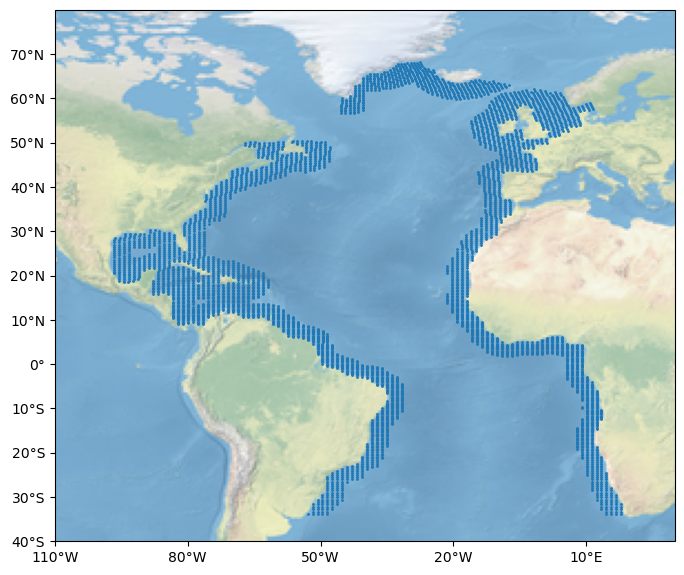

In [58]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=0))
ax.set_extent([-110, 30, -40, 80], crs=ccrs.PlateCarree())

ax.scatter(tlong_atlantic, tlat_atlantic, s=1, alpha=1, transform=ccrs.PlateCarree())

ax.set_xticks(np.arange(-110, 30, 30), crs= ccrs.PlateCarree())
ax.set_yticks(np.arange(-40, 80, 10), crs= ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

ax.stock_img()

/glade/work/eyankovsky/conda-envs/mcdr/lib/python3.7/site-packages/ipykernel_launcher.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


CPU times: user 2.87 s, sys: 48 ms, total: 2.92 s
Wall time: 3.05 s


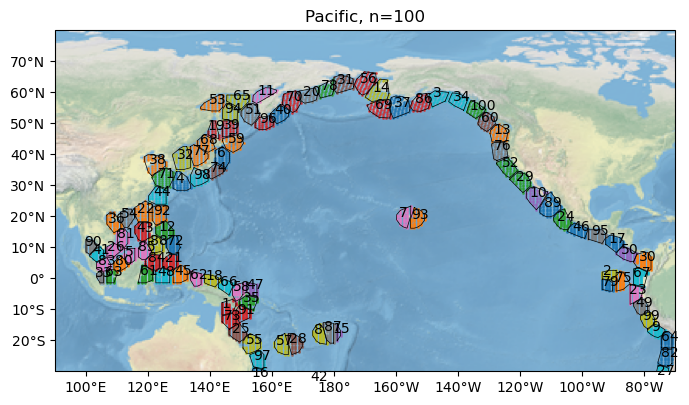

In [77]:
%%time
polygon_vertices, polygon_ind_inAtlanticPOP, cluster_centers = get_polygons(mask_atlantic*region_mask_eez, 100, convert_lon=True, save_ind=True)
#polygon_vertices, polygon_ind_inAtlanticPOP, cluster_centers = get_polygons(mask_atlantic, 100, convert_lon=True, save_ind=True)

lon_extend = {'Atlantic': [-110, 30], 'EEZ': [-180, 180], 'Pacific': [90, 290]}
lat_extend = {'Atlantic': [-40, 80], 'EEZ': [-90, 90], 'Pacific': [-30,80]}

plot_polygons(polygon_vertices, cluster_centers, lon_extend['Pacific'], lat_extend['Pacific'], remove=[], region='Pacific', center_lon=180, save=False)

**THIS IS THE END PRODUCT OF POLYGON MASKS**

In [72]:
polygon_mask_EEZ = get_polygon_mask(tlong, mask_atlantic*region_mask_eez, polygon_ind_inAtlanticPOP)
#polygon_mask_EEZ = get_polygon_mask(tlong, mask_atlantic, polygon_ind_inAtlanticPOP)

In [73]:
polygon_mask_EEZ.shape

(100, 384, 320)

Check the masks

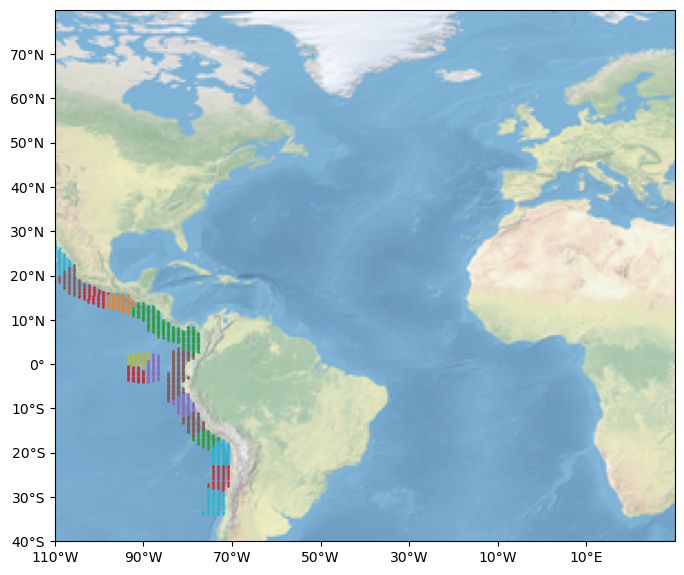

In [74]:
fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=0))
ax.set_extent([-110,30, -40, 80], crs=ccrs.PlateCarree())
ax.stock_img()

# a list of colors
colors = list(mcolors.TABLEAU_COLORS.values())
ind_color = np.arange(len(colors)) # 0- 9

for i in range(len(polygon_mask_EEZ)):
    
    # plot polygon masks
    index = np.where(polygon_mask_EEZ[i] == 1)
    ax.scatter(tlong[index], tlat[index], c=colors[random.choice(ind_color)], s=1, alpha=0.8, transform=ccrs.PlateCarree())

ax.set_xticks(np.arange(-110,30, 20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-40, 80, 10), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)  

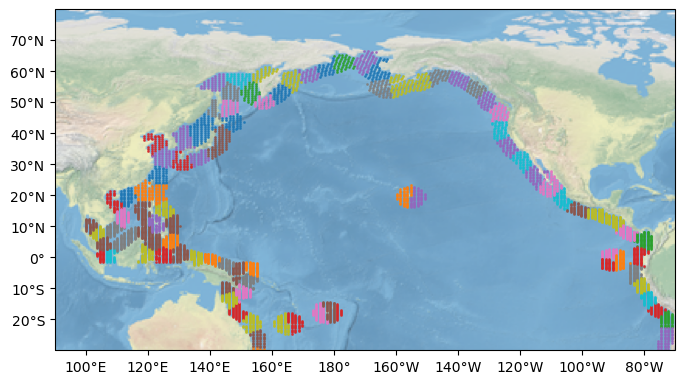

In [75]:
fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax.set_extent([90, 290, -30, 80], crs=ccrs.PlateCarree())
ax.stock_img()

# a list of colors
colors = list(mcolors.TABLEAU_COLORS.values())
ind_color = np.arange(len(colors)) # 0- 9

for i in range(len(polygon_mask_EEZ)):
    
    # plot polygon masks
    index = np.where(polygon_mask_EEZ[i] == 1)
    ax.scatter(tlong[index], tlat[index], c=colors[random.choice(ind_color)], s=1, alpha=0.8, transform=ccrs.PlateCarree())

ax.set_xticks(np.arange(100, 290, 20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-20, 80, 10), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)  